**Title:** "Convert Bathymetry Elevation  
**Author:** J. Daniel Vélez (based on NXSDB demo)  
**Date:** 06/03/2025

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import dataretrieval.nwis as nwis
import dataretrieval as dr
from IPython.display import display, HTML
import os
import base64
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import help_fxs as helpfxs
import re
from pyproj import Transformer
import statistics
import requests

In [2]:
os.chdir("../0_data/External/Bathymetries/namerica/Ohio/NXSDB") # Uncomment to change to the directory where the data is stored
os.getcwd()

'/Users/josele/Library/CloudStorage/GoogleDrive-ejdvc757@gmail.com/Other computers/My MacBook Pro/PhD/Dissertation/0_data/External/Bathymetries/namerica/Ohio/NXSDB'

In [3]:
station_master_pth = "./NXSDB_WY2022_CONUS_station_master.txt"
station_master = pd.read_csv(station_master_pth, sep="\t", dtype={"station": str})

In [4]:
# Path to GPKG file
gpkg_pth = "./NXSDB_WY2022_CONUS.gpkg"
schema_path = "./NXSDB_schema_v1.0.0.json"

In [5]:
## Function select data for a given river
def river_data(river_name):
    river_selected = station_master[station_master["station_nm"].str.contains(river_name)]

    # Convert station IDs to strings
    station_ids_str = river_selected["station"].astype(str).tolist()

    #define the number of chuncks
    n_chunks = 1

    # Split the list into smaller chunks
    split_list = np.array_split(station_ids_str, n_chunks)
    data_list = [] # List to store results

    for site_list in split_list:

        # Get discharge measurements for the current chunk
        data_chunk = nwis.get_discharge_measurements(sites=site_list.tolist(), start='2021-10-01', end='2022-09-30')[0]
        data_list.append(data_chunk) # append the data to the list

    # Combine all the data chunks into a single dataframe
    nwis_mmts = pd.concat(data_list, ignore_index=True)

    # Querying the database
    # The read_gpkg() function takes the path to the GeoPackage, a single layer name or list of layer names, ant the path to the schema file
    gpkg_geom = helpfxs.read_gpkg(gpkg_pth, "geometry", schema_path) 
    gpkg_geom_georef = gpkg_geom[gpkg_geom['station_nm'].str.contains(river_name)]
    station_list = gpkg_geom_georef.station
    print(f"After subsetting, there are {len(station_list)} stations In the {river_name}")
    return nwis_mmts, gpkg_geom_georef, station_list

In [6]:
river_name = "OHIO RIVER"
nwis_result, river_gpkg, station_list = river_data(river_name)

After subsetting, there are 10 stations In the OHIO RIVER


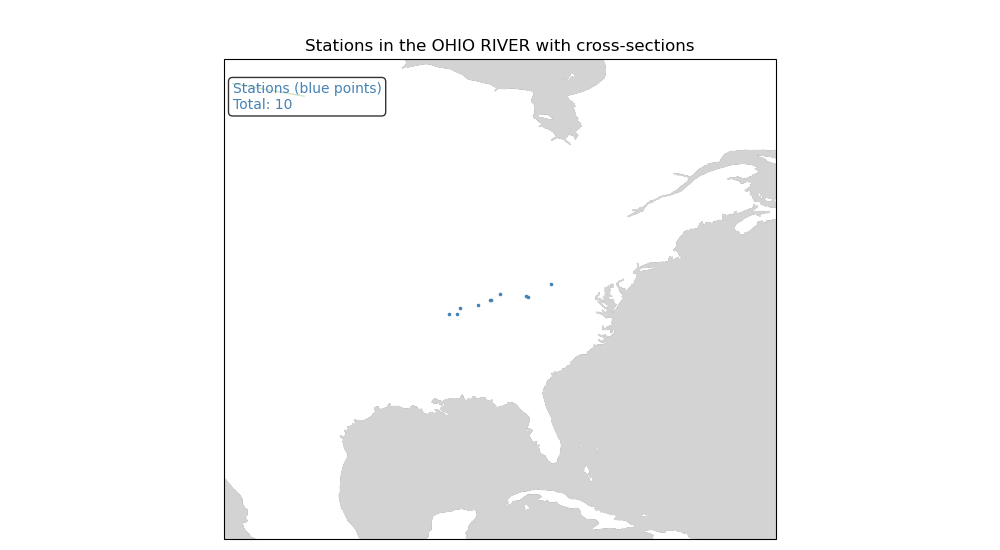

In [7]:
helpfxs.plot_gpkg(river_gpkg, title=f"Stations in the {river_name} with cross-sections", legend="Stations", fig=[10,5.5],buffer_degrees=18.0)

In [8]:
stations_w_georeferenced_mmts = station_list + "_record"
georeferenced_records = helpfxs.read_gpkg(gpkg_pth, stations_w_georeferenced_mmts, schema_path)

# Show first two record layers in the dictionary
dict(list(georeferenced_records.items()))

{'03294500_record':    fid                  mmt_ID              mmt_Timestamp CrossSectionType  \
 0    1  03294500_mb_20220502_1  2022-05-02T14:15:59-05:00               mb   
 1    2  03294500_mb_20220712_1  2022-07-12T13:35:15-05:00               mb   
 2    3  03294500_mb_20220927_1  2022-09-27T09:57:48-05:00               mb   
 
   Georeferenced MeasurementQualityCode ChannelNumber  ChannelArea  \
 0         false                   FAIR             1    33734.973   
 1          true                   FAIR             1    25669.585   
 2         false                   FAIR             1    26783.016   
 
   ChannelArea_units  ChannelWidth  ... ChannelEvennessCode  \
 0                sf      1691.437  ...                EVEN   
 1                sf      1639.597  ...                UNSP   
 2                sf      1595.930  ...                EVEN   
 
   DeploymentMethodCode SectionLocationCode SectionDistanceMeasure  \
 0                 MBOT                DNST              

In [9]:
georeferenced_records[list(georeferenced_records.keys())[0]]

,fid,mmt_ID,mmt_Timestamp,CrossSectionType,Georeferenced,MeasurementQualityCode,ChannelNumber,ChannelArea,ChannelArea_units,ChannelWidth,...,ChannelEvennessCode,DeploymentMethodCode,SectionLocationCode,SectionDistanceMeasure,SectionDistanceMeasure_units,SoftwareVersionText,MovingBedEffected,CrossSectionColumns,GageHeight_ft,Discharge_cfs
0,1,03294500_mb_20220502_1,2022-05-02T14:15:59-05:00,mb,false,FAIR,1,33734.973,sf,1691.437,...,EVEN,MBOT,DNST,1000.0,ft,QRev 4.29,false,"Distance_Meters, Distance_X_Meters, Distance_Y...",19.41,110000
1,2,03294500_mb_20220712_1,2022-07-12T13:35:15-05:00,mb,true,FAIR,1,25669.585,sf,1639.597,...,UNSP,MBOT,DNST,4000.0,ft,QRev 4.31,false,"Latitude_Degrees, Longitude_Degrees, Distance_...",15.10,69400
2,3,03294500_mb_20220927_1,2022-09-27T09:57:48-05:00,mb,false,FAIR,1,26783.016,sf,1595.930,...,EVEN,MBOT,DNST,61500.0,ft,QRev 4.32,false,"Distance_Meters, Distance_X_Meters, Distance_Y...",11.15,26500


In [10]:
# Initialize an empty list to store the extracted mmt_id values
georeferenced_mmt_IDs = []

# Iterate through each DataFrame in the dictionary
for df in georeferenced_records.values():
    # Extract the mmt_id values where Georeferenced is true
    mmt_IDs = df.loc[df['Georeferenced'] == "true", 'mmt_ID'].tolist()
    # Append the extrtacted mmt_id values to the list
    georeferenced_mmt_IDs.extend(mmt_IDs)

# First 10 measurements IDs (or less)
print (georeferenced_mmt_IDs[:10])
print(f"Now there are {len(georeferenced_mmt_IDs)} georeferenced cross-sections for gages referenced to NAVD88. Notice how they are all moving-boat ADCP measurements as indicated by the 'mb' string in the mmt_ID. Let's look at the data.")

['03294500_mb_20220712_1', '03292494_mb_20220310_1', '03303280_mb_20220308_1', '03216070_mb_20220215_1', '03277200_mb_20220505_1', '03381700_mb_20220427_1']
Now there are 6 georeferenced cross-sections for gages referenced to NAVD88. Notice how they are all moving-boat ADCP measurements as indicated by the 'mb' string in the mmt_ID. Let's look at the data.


In [11]:
georeferenced_xs = helpfxs.read_gpkg(gpkg_pth, georeferenced_mmt_IDs, schema_path)

#Show the first two records in the dictionary
dict(list(georeferenced_xs.items())[:])

{'03294500_mb_20220712_1':        fid  Latitude_Degrees  Longitude_Degrees  Distance_Meters  \
 0        1         38.277692         -85.818354           30.617   
 1        2         38.277694         -85.818355           30.818   
 2        3         38.277695         -85.818356           31.019   
 3        4         38.277697         -85.818357           31.220   
 4        5         38.277699         -85.818358           31.421   
 ...    ...               ...                ...              ...   
 2307  2308         38.281591         -85.820671          494.016   
 2308  2309         38.281593         -85.820672          494.217   
 2309  2310         38.281594         -85.820673          494.418   
 2310  2311         38.281596         -85.820674          494.619   
 2311  2312         38.281598         -85.820675          494.820   
 
       Distance_X_Meters  Distance_Y_Meters  Depth_Meters  
 0                   NaN                NaN           NaN  
 1               -30.726

In [12]:
# Initialize a dictionary to store individual GeoDataFrames
gdf_dict = {}

# Iterate through each DatFrame in the dictionary
for key, df in georeferenced_xs.items():
    # Check for NaN values in Latitude or Longitude columns
    if df['Latitude_Degrees'].isna().any() or df['Longitude_Degrees'].isna().any():
        print(f"Skipping{key} due to NaN values in latitude or longitude")
        continue

    # Add the mmt_ID column with the current dictionary key
    df['mmt_ID'] = key
    # Create a geometry column using the Latitude and Longitude columns
    geometry = [Point(xy) for xy in zip(df['Longitude_Degrees'], df['Latitude_Degrees'])]
    # Create the GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=geometry)
    # Set the coordinate references system (CRS) to EPSG:4326 (WGS84
    gdf.set_crs(epsg=4326, inplace=True)
    # Add the GeoDataFrame to the dictionary
    gdf_dict[key] = gdf

print(gdf)

     fid  Latitude_Degrees  Longitude_Degrees  Distance_Meters  \
0      1         37.692445         -88.126313           14.659   
1      2         37.692449         -88.126321           15.522   
2      3         37.692453         -88.126329           16.385   
3      4         37.692458         -88.126337           17.248   
4      5         37.692462         -88.126345           18.110   
..   ...               ...                ...              ...   
873  874         37.696193         -88.133421          767.857   
874  875         37.696198         -88.133430          768.720   
875  876         37.696202         -88.133438          769.583   
876  877         37.696206         -88.133446          770.445   
877  878         37.696210         -88.133454          771.308   

     Distance_X_Meters  Distance_Y_Meters  Depth_Meters  \
0                  NaN                NaN           NaN   
1              -14.527              5.468         4.970   
2              -15.264        

In [13]:
new_gdf_dict = {key.split('_mb')[0]: value for key, value in gdf_dict.items()}

In [14]:
#mb_3294500 = gdf_dict['03294500_mb_20220712_1']
#mb_3294500
new_gdf_dict

{'03294500':        fid  Latitude_Degrees  Longitude_Degrees  Distance_Meters  \
 0        1         38.277692         -85.818354           30.617   
 1        2         38.277694         -85.818355           30.818   
 2        3         38.277695         -85.818356           31.019   
 3        4         38.277697         -85.818357           31.220   
 4        5         38.277699         -85.818358           31.421   
 ...    ...               ...                ...              ...   
 2307  2308         38.281591         -85.820671          494.016   
 2308  2309         38.281593         -85.820672          494.217   
 2309  2310         38.281594         -85.820673          494.418   
 2310  2311         38.281596         -85.820674          494.619   
 2311  2312         38.281598         -85.820675          494.820   
 
       Distance_X_Meters  Distance_Y_Meters  Depth_Meters  \
 0                   NaN                NaN           NaN   
 1               -30.726            

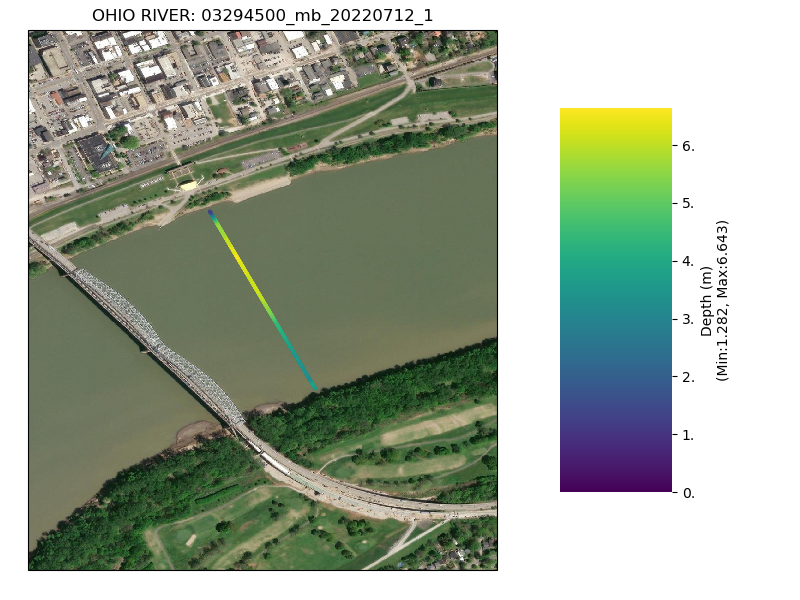

In [15]:
helpfxs.plot_gpkg(new_gdf_dict['03294500'],
                    basemap="image",
                    plot_col=(0,None,"Depth_Meters"),
                    title = f"{river_name}: 03294500_mb_20220712_1",
                    legend="Depth (m)",
                    buffer_degrees=0.004,
                    fig=[8,6],
                    hist=False)

<Figure size 1000x600 with 0 Axes>

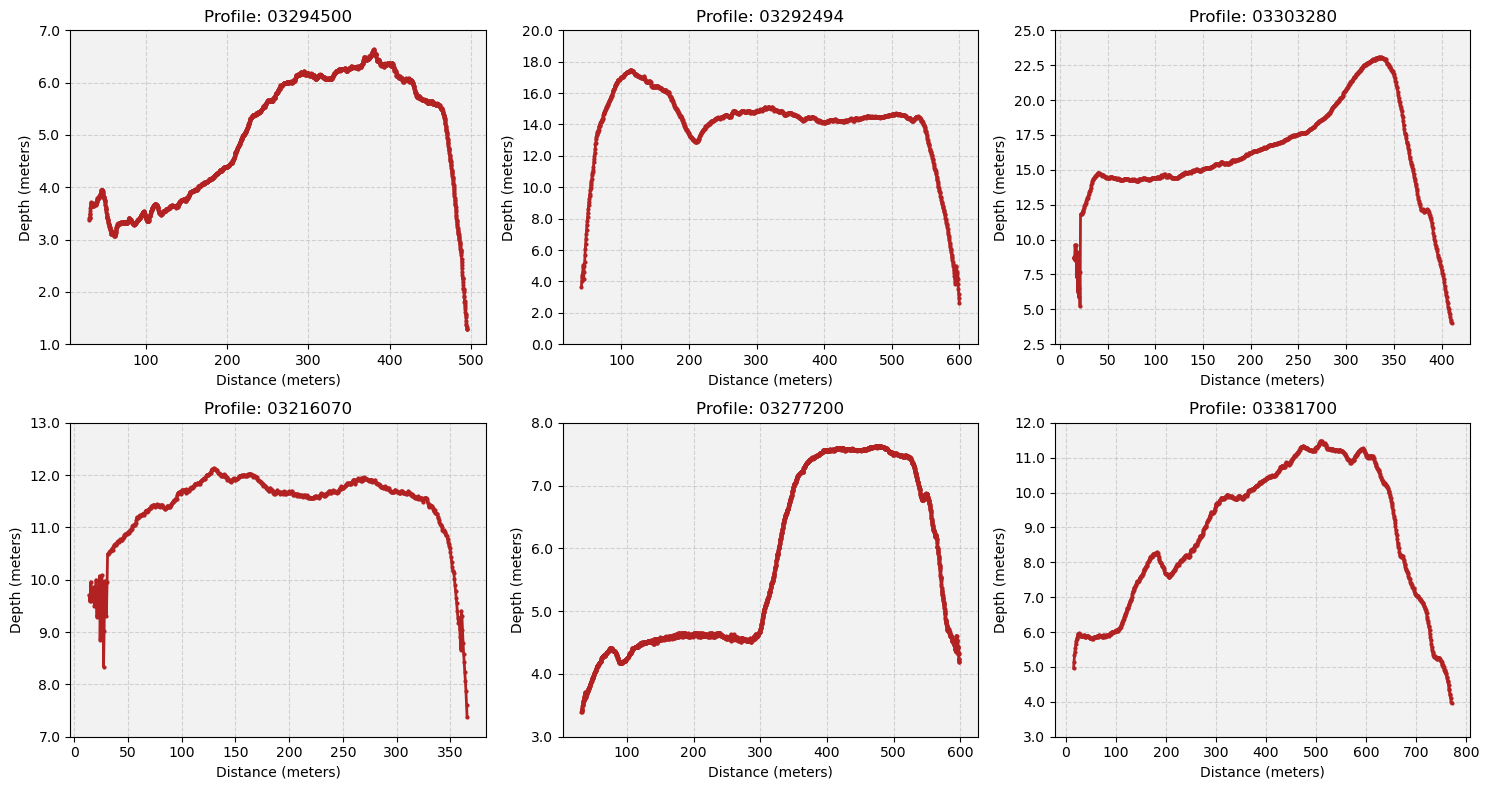

In [16]:
# Iterate over the dictionary and plot each dataframe
plt.figure(figsize=(10, 6))
helpfxs.plot_mb_xs_grid(new_gdf_dict,depth_column='Depth_Meters',  color='firebrick', units="meters")

**Convert Bathymetry Elevation**

In [17]:
# Given that the list of georeferenced cx's are store as 'georeferenced_mmt_IDs' with a format of 'gageID_mb_date', 
# I want extract only the gageID part to match with the gage codes in the USGS website
georef_cx_gages = [re.match(r'(\d+)_mb_', item).group(1) for item in georeferenced_mmt_IDs]
georef_cx_gages

['03294500', '03292494', '03303280', '03216070', '03277200', '03381700']

In [18]:
def datum_trans(gaugeCode, gdf_dic):
    results = {}
    for gaugeCodes in gaugeCode:
        try:
            # Get gauge information
            river_gauge, _ = nwis.get_info(sites = gaugeCodes)
            # params = {"series CatalogOutput": "true",
            # "sites = gaugeCode,
            # "format": "rdb"}
            # URL to the USGS site
            #url = f"https://waterservices.usgs.gov/nwis/site/?seriesCatalogOutput=true&sites={gaugeCodes}&format=rdb"

            # Get river stage data
            river_stage, metadata = nwis.get_iv(sites = gaugeCodes,
                                                parameterCd = "00065",
                                                start = "2021-10-01",
                                                end = "2025-02-01",
                                                )
    
            # Extract first datum value (if available)
            gage_datum_ft = float(river_gauge["alt_va"].iloc[0])
            # Convert gage height to NAVD88 meters. If also water levels want to be converted to meters do this: 
            river_stage["elevation_NAVD88(m)"] = (gage_datum_ft * 0.3048)
            river_stage["stage_NAVD88(m)"] = river_stage['00065'] * 0.3048 #+ river_stage["elevation_NAVD88(m)"]
            river_stage["av_stage_NAVD88(m)"] = river_stage["stage_NAVD88(m)"].mean()
            
            # Store results
            results[gaugeCodes] = river_stage
        except Exception as e:
            print(f"Error processing {gaugeCodes}: {e}")
            results[gaugeCodes] = None

# Step 2: Process gdf_dic and update Depth_NAVD88(m)
    for base_id, gdf in gdf_dic.items():
        try:
            print(f"Processing base_id: {base_id}")

            # Check if base_id has valid results
            if base_id not in results or results[base_id] is None:
                print(f"Skipping {base_id} due to missing data in results.")
                continue  # Skip this entry

            river_stage = results[base_id]  # Retrieve the corresponding DataFrame

            if "Depth_Meters" in gdf.columns:
                # Extract the first valid (non-NaN) value for av_stage
                av_stage = river_stage["av_stage_NAVD88(m)"].dropna().iloc[0] if not river_stage["av_stage_NAVD88(m)"].dropna().empty else np.nan
                
                # Extract the first valid (non-NaN) value for elevation
                elevation = river_stage["elevation_NAVD88(m)"].dropna().iloc[0] if not river_stage["elevation_NAVD88(m)"].dropna().empty else np.nan
                
                # Compute only if Depth_Meters is valid
                gdf["Depth_NAVD88(m)"] = np.where(
                    pd.notna(gdf["Depth_Meters"]),
                    av_stage - gdf["Depth_Meters"] + elevation,
                    np.nan  # Keep NaNs where original data is NaN
                )

                print(f"Updated 'Depth_NAVD88(m)' for {base_id}")
            else:
                print(f"Column 'Depth_Meters' not found for {base_id}")

        except Exception as e:
            print(f"Error processing {base_id}: {e}")
            continue  # Skip and move to the next item


    return results, gdf_dic


In [19]:
result, new_dict = datum_trans(georef_cx_gages, new_gdf_dict)

Error processing 03292494: '00065'
Error processing 03277200: '00065'
Processing base_id: 03294500
Updated 'Depth_NAVD88(m)' for 03294500
Processing base_id: 03292494
Skipping 03292494 due to missing data in results.
Processing base_id: 03303280
Updated 'Depth_NAVD88(m)' for 03303280
Processing base_id: 03216070
Updated 'Depth_NAVD88(m)' for 03216070
Processing base_id: 03277200
Skipping 03277200 due to missing data in results.
Processing base_id: 03381700
Updated 'Depth_NAVD88(m)' for 03381700


In [23]:
result['03294500']

,site_no,00065,00065_cd,elevation_NAVD88(m),stage_NAVD88(m),av_stage_NAVD88(m)
datetime,,,,,,
2021-10-01 04:00:00+00:00,03294500,12.51,A,113.745264,3.813048,5.816798
2021-10-01 04:15:00+00:00,03294500,12.46,A,113.745264,3.797808,5.816798
2021-10-01 04:30:00+00:00,03294500,12.45,A,113.745264,3.794760,5.816798
2021-10-01 04:45:00+00:00,03294500,12.44,A,113.745264,3.791712,5.816798
2021-10-01 05:00:00+00:00,03294500,12.42,A,113.745264,3.785616,5.816798
...,...,...,...,...,...,...
2025-02-02 03:45:00+00:00,03294500,30.54,P,113.745264,9.308592,5.816798
2025-02-02 04:00:00+00:00,03294500,30.58,P,113.745264,9.320784,5.816798
2025-02-02 04:15:00+00:00,03294500,30.62,P,113.745264,9.332976,5.816798


In [24]:
new_dict['03294500']

,fid,Latitude_Degrees,Longitude_Degrees,Distance_Meters,Distance_X_Meters,Distance_Y_Meters,Depth_Meters,mmt_ID,geometry,Depth_NAVD88(m)
0,1,38.277692,-85.818354,30.617,NaN,NaN,NaN,03294500_mb_20220712_1,POINT (-85.81835 38.27769),NaN
1,2,38.277694,-85.818355,30.818,-30.726,-2.380,3.383,03294500_mb_20220712_1,POINT (-85.81835 38.27769),116.179062
2,3,38.277695,-85.818356,31.019,-30.962,-1.878,3.404,03294500_mb_20220712_1,POINT (-85.81836 38.2777),116.158062
3,4,38.277697,-85.818357,31.220,-31.189,-1.396,3.404,03294500_mb_20220712_1,POINT (-85.81836 38.2777),116.158062
4,5,38.277699,-85.818358,31.421,-31.407,-0.931,3.404,03294500_mb_20220712_1,POINT (-85.81836 38.2777),116.158062
...,...,...,...,...,...,...,...,...,...,...
2307,2308,38.281591,-85.820671,494.016,-235.828,434.094,1.365,03294500_mb_20220712_1,POINT (-85.82067 38.28159),118.197062
2308,2309,38.281593,-85.820672,494.217,-235.913,434.276,1.326,03294500_mb_20220712_1,POINT (-85.82067 38.28159),118.236062
2309,2310,38.281594,-85.820673,494.418,-235.999,434.458,1.299,03294500_mb_20220712_1,POINT (-85.82067 38.28159),118.263062
2310,2311,38.281596,-85.820674,494.619,-236.084,434.640,1.286,03294500_mb_20220712_1,POINT (-85.82067 38.2816),118.276062


<Figure size 1000x600 with 0 Axes>

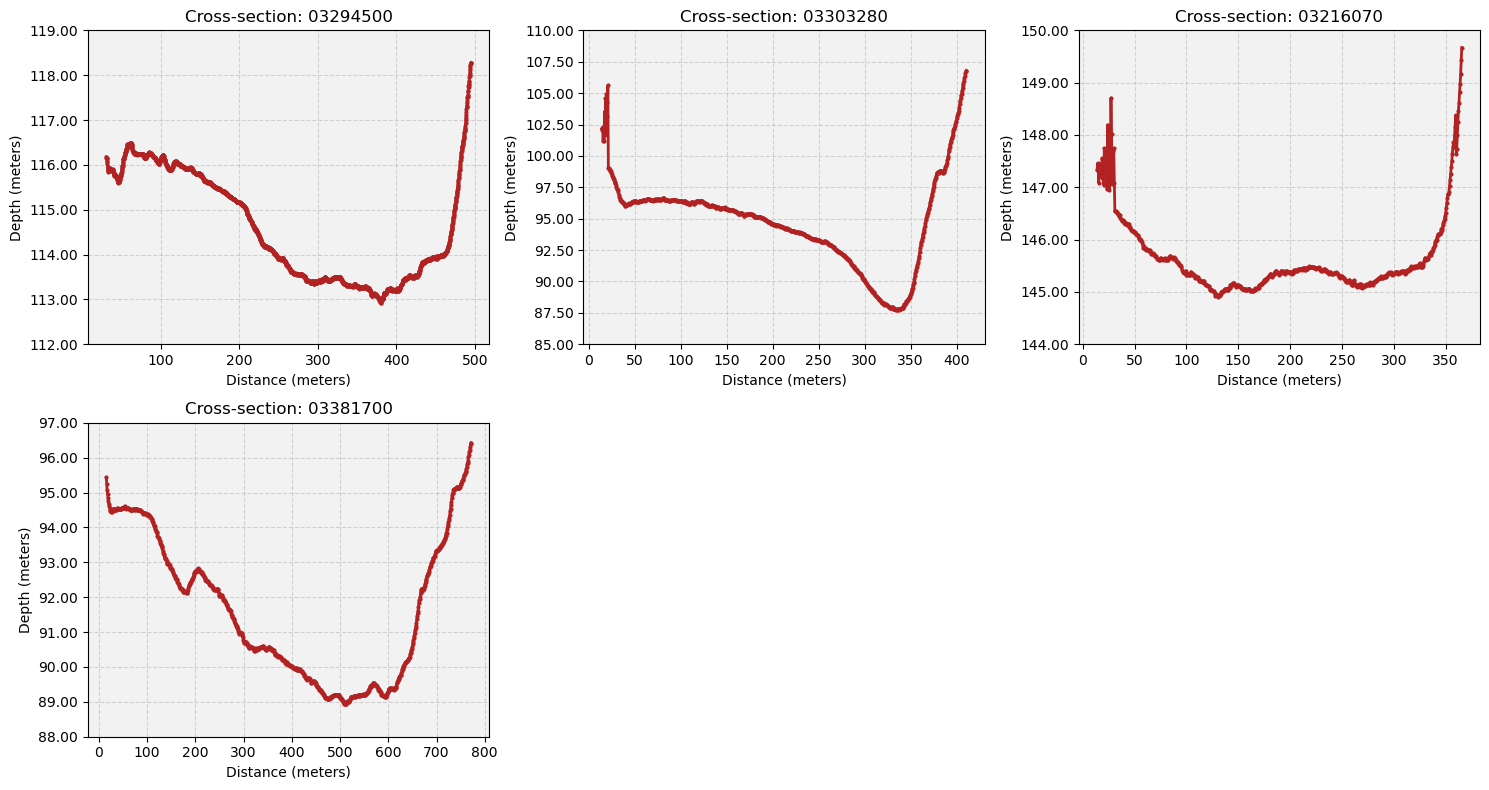

In [21]:
plt.figure(figsize=(10, 6))
helpfxs.plot_mb_xs_dict(new_dict, result, depth_column = 'Depth_NAVD88(m)', colors=['firebrick'] * len(new_dict), units="meters")

In [26]:
## Define the coordinate transformation (NAVD88 to EGM2008)
# Define the coordinate transformation (NAVD88 to EGM2008)
transformer = Transformer.from_crs("EPSG:6349", "EPSG:9057+EPSG:3855", always_xy=True)
bath_EGM08 = {}

for key in new_dict.keys():
    # Ensure the DataFrame has the required columns
    required_columns = {"Latitude_Degrees", "Longitude_Degrees", "Distance_Meters", "geometry", "Depth_NAVD88(m)"}
    
    # Skip if the DataFrame does not have the required column(s)
    if not required_columns.issubset(new_dict[key].columns):
        print(f"Skipping {key} because it is missing required columns: {required_columns - set(new_dict[key].columns)}")
        continue  # Skip this key

    # Explicitly create a copy to avoid SettingWithCopyWarning
    bath_EGM08[key] = new_dict[key][list(required_columns)].copy()

    # Apply transformation correctly (Longitude first due to always_xy=True)
    transformed_coords = transformer.transform(
        bath_EGM08[key]['Longitude_Degrees'].values,  
        bath_EGM08[key]['Latitude_Degrees'].values,  
        bath_EGM08[key]['Depth_NAVD88(m)'].values
    )

    # Assign transformed values using .loc to avoid the warning
    bath_EGM08[key].loc[:, "Longitude_EGM2008"] = transformed_coords[0]
    bath_EGM08[key].loc[:, "Latitude_EGM2008"] = transformed_coords[1]
    bath_EGM08[key].loc[:, "Depth_EGM2008(m)"] = transformed_coords[2]

print("Transformation completed successfully.")

Skipping 03292494 because it is missing required columns: {'Depth_NAVD88(m)'}
Skipping 03277200 because it is missing required columns: {'Depth_NAVD88(m)'}
Transformation completed successfully.


In [27]:
bath_EGM08

{'03294500':                         geometry  Latitude_Degrees  Longitude_Degrees  \
 0     POINT (-85.81835 38.27769)         38.277692         -85.818354   
 1     POINT (-85.81835 38.27769)         38.277694         -85.818355   
 2      POINT (-85.81836 38.2777)         38.277695         -85.818356   
 3      POINT (-85.81836 38.2777)         38.277697         -85.818357   
 4      POINT (-85.81836 38.2777)         38.277699         -85.818358   
 ...                          ...               ...                ...   
 2307  POINT (-85.82067 38.28159)         38.281591         -85.820671   
 2308  POINT (-85.82067 38.28159)         38.281593         -85.820672   
 2309  POINT (-85.82067 38.28159)         38.281594         -85.820673   
 2310   POINT (-85.82067 38.2816)         38.281596         -85.820674   
 2311   POINT (-85.82068 38.2816)         38.281598         -85.820675   
 
       Distance_Meters  Depth_NAVD88(m)  Longitude_EGM2008  Latitude_EGM2008  \
 0              30

<Figure size 1000x600 with 0 Axes>

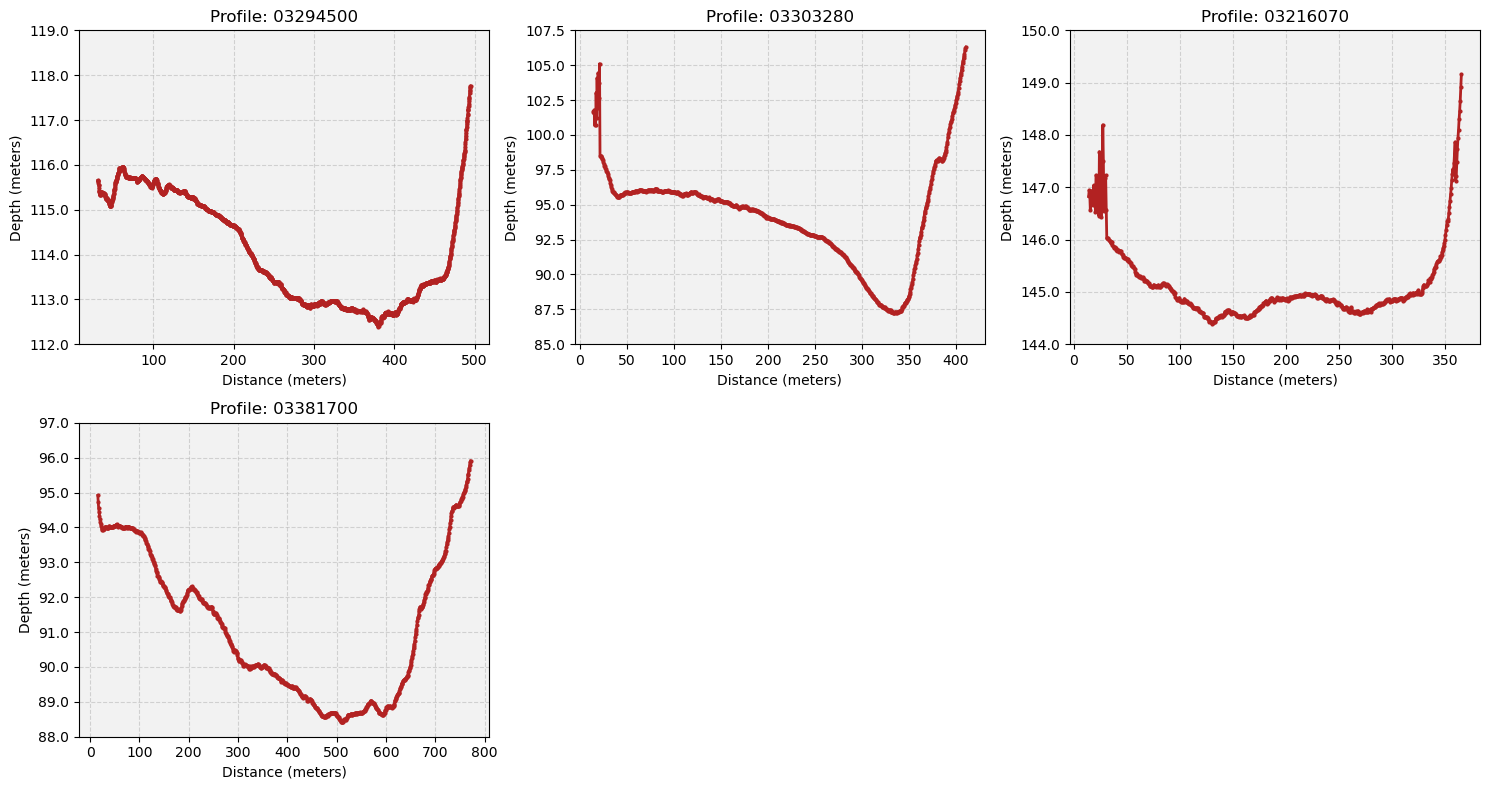

In [31]:
plt.figure(figsize=(10, 6))
helpfxs.plot_mb_xs_grid(bath_EGM08, depth_column='Depth_EGM2008(m)', color='firebrick', units="meters")